In [ ]:
import torch
import torchvision as tv
from torchvision.models import resnet18, vgg16, inception_v3, densenet161

import time

In [ ]:
def transform_load_data(size, batch_size):
    transforms = tv.transforms.Compose([
        tv.transforms.Grayscale(3),
        tv.transforms.Resize(size),
        tv.transforms.ToTensor()
    ])
    
    train_ds = tv.datasets.EMNIST('.',
                              split='balanced',
                              train=True,
                              transform=transforms,
                              download=True)

    test_ds = tv.datasets.EMNIST('.',
                             train=False,
                             split='balanced',
                             transform=transforms,
                             download=True)
    
    train = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=batch_size)
    test = torch.utils.data.DataLoader(train_ds, shuffle=False, batch_size=batch_size)
    
    return train, test

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
transforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((28, 28)),
    tv.transforms.ToTensor()
])

train_ds = tv.datasets.EMNIST('.',
                              split='balanced',
                              train=True,
                              transform=transforms,
                              download=True)

test_ds = tv.datasets.EMNIST('.',
                             train=False,
                             split='balanced',
                             transform=transforms,
                             download=True)

100%|██████████| 561753746/561753746 [00:05<00:00, 111152184.07it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [ ]:
labels_map  = dict(zip([i for i in range(len(train_ds.classes))], train_ds.classes))

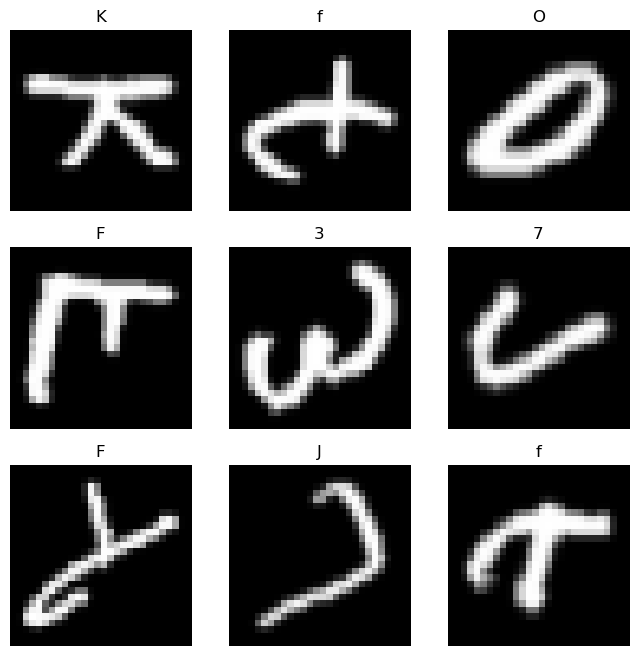

In [ ]:
# Отрисовка рандомных картинок
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_ds), size=(1,)).item()
    img, label = train_ds[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img[2:].squeeze(), cmap="gray")
plt.show()

In [ ]:
# Проверка на дисбаланс классов
count_dict = {}
for i in range(len(train_ds)):
  if labels_map[train_ds[i][1]] not in count_dict:
    count_dict[labels_map[train_ds[i][1]]] = 1
  else:
    count_dict[labels_map[train_ds[i][1]]] += 1

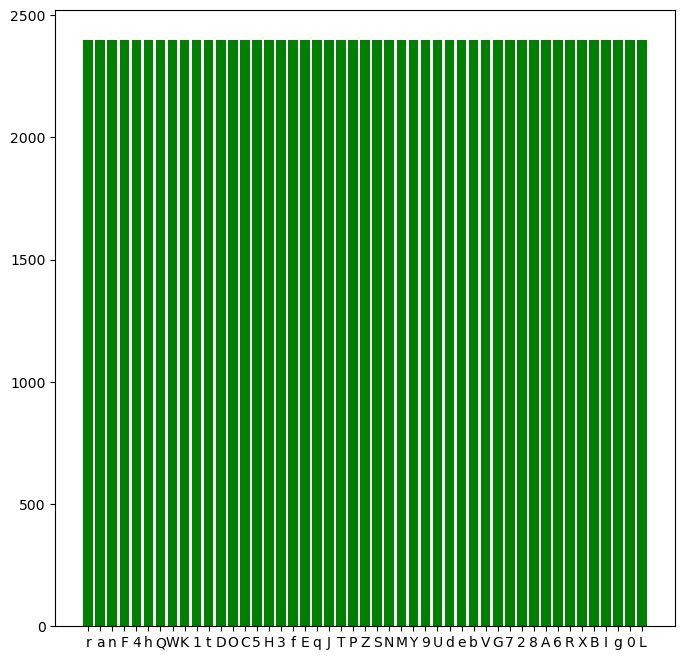

In [ ]:
plt.figure(figsize=(8,8))
plt.bar(list(count_dict.keys()), count_dict.values(), color='g')
plt.show()

In [ ]:
def train_model(epochs, batch_size, model, trainer, train_ds, test_ds, train_lost_list, test_loss_list):

  model = model.to(device)

  loss = torch.nn.CrossEntropyLoss()

  for ep in range(epochs):

    train_iter, train_pass = 0, 0
    train_loss, train_acc = 0., 0.

    start = time.time()

    model.train()

    for X, y in train_ds:
      X, y = X.to(device), y.to(device)
      trainer.zero_grad()
      _, y_pred = model(X)
      l = loss(y_pred, y)
      l.backward()
      trainer.step()
      train_loss += l.item()
      train_acc += (y_pred.argmax(dim=1) == y).sum().item()
      train_iter += 1
      train_pass += len(X)

    train_lost_list.append(train_loss / train_iter)

    test_iter, test_pass  = 0, 0
    test_loss, test_acc = 0., 0.

    model.eval()
    with torch.no_grad():
        for X, y in test_ds:
              X, y = X.to(device), y.to(device)
              _, y_pred = model(X)
              l = loss(y_pred, y)
              test_loss += l.item()
              test_acc += (y_pred.argmax(dim=1) == y).sum().item()
              test_iter += 1
              test_pass += len(X)

    test_loss_list.append(test_loss / test_iter)

    print(f"epoch: {ep}",
          f"time: {time.time() - start}",
          f"train_loss: {train_loss / train_iter}",
          f"train_acc: {train_acc / train_pass}",
          f"test_loss: {test_loss / test_iter}",
          f"test_acc: {test_acc / test_pass}")

## ResNet 18

In [ ]:
model_resnet = resnet18(pretrained=False)
model_resnet.fc = torch.nn.Linear(in_features=512, out_features=len(train_ds.classes), bias=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
trainer = torch.optim.Adam(model_resnet.parameters(), lr=1e-3)

In [ ]:
train, test = transform_load_data(28, 256)

In [ ]:
train_list_resnet, test_list_resnet  = [], []

In [ ]:
train_model(epochs=10, batch_size=256, model=model_resnet, trainer=trainer, train_ds=train, test_ds=test, train_lost_list=train_list_resnet, test_loss_list=test_list_resnet)

epoch: 0 time: 87.14096069335938 train_loss: 0.5406820356440382 train_acc: 0.8167375886524822 test_loss: 0.4282436987169746 test_acc: 0.8482712765957446
epoch: 1 time: 76.14347171783447 train_loss: 0.35409961965213826 train_acc: 0.8717198581560284 test_loss: 0.36811489701406214 test_acc: 0.8664716312056737
epoch: 2 time: 76.92003083229065 train_loss: 0.31430345989949576 train_acc: 0.8824202127659575 test_loss: 0.3342758000167319 test_acc: 0.8753014184397163
epoch: 3 time: 76.22987198829651 train_loss: 0.28946668017748534 train_acc: 0.8910638297872341 test_loss: 0.27375122097208926 test_acc: 0.8933510638297872
epoch: 4 time: 76.8018114566803 train_loss: 0.2711494469047944 train_acc: 0.8965514184397163 test_loss: 0.29868341282922395 test_acc: 0.8854609929078014
epoch: 5 time: 76.89042615890503 train_loss: 0.2576680381754899 train_acc: 0.9002304964539007 test_loss: 0.26160531205520066 test_acc: 0.8984574468085106
epoch: 6 time: 80.81113004684448 train_loss: 0.24577489657466914 train_acc: 

## VGG16

In [ ]:
model_vgg = vgg16(pretrained=False)
model_vgg.classifier[6] = torch.nn.Linear(in_features=4096, out_features=len(train_ds.classes), bias=True)
trainer_vgg = torch.optim.Adam(model_vgg.parameters(), lr=1e-3)
train_list_vgg, test_list_vgg  = [], []
train_vgg, test_vgg = transform_load_data(32, 256)

In [ ]:
train_model(epochs=10, batch_size=256, model=model_vgg, trainer=trainer_vgg, train_ds=train_vgg, test_ds=test_vgg, train_lost_list=train_list_vgg, test_loss_list=test_list_vgg)

epoch: 0 time: 150.18837928771973 train_loss: 3.9368960235664905 train_acc: 0.020177304964539008 test_loss: 3.8501591677027767 test_acc: 0.02127659574468085
epoch: 1 time: 151.58604311943054 train_loss: 3.8503402712123465 train_acc: 0.020177304964539008 test_loss: 3.8501564823851293 test_acc: 0.02127659574468085
epoch: 2 time: 151.5641040802002 train_loss: 3.8503324477310352 train_acc: 0.020425531914893616 test_loss: 3.8501572495415095 test_acc: 0.02127659574468085
epoch: 3 time: 151.55623745918274 train_loss: 3.850335315241565 train_acc: 0.019982269503546098 test_loss: 3.8501584508251443 test_acc: 0.02127659574468085
epoch: 4 time: 152.81336784362793 train_loss: 3.8503526441094014 train_acc: 0.020257092198581562 test_loss: 3.8501561650343223 test_acc: 0.02127659574468085
epoch: 5 time: 153.14751052856445 train_loss: 3.8503278518209654 train_acc: 0.02028368794326241 test_loss: 3.8501579566877715 test_acc: 0.02127659574468085
epoch: 6 time: 153.49369764328003 train_loss: 3.8503435225713

## Inception_v3 

In [ ]:
model_v3 = inception_v3(pretrained=False)
model_v3.fc = torch.nn.Linear(in_features=2048, out_features=len(train_ds.classes), bias=True)
trainer_v3 = torch.optim.Adam(model_v3.parameters(), lr=1e-3)
train_list_v3, test_list_v3  = [], []

transforms = tv.transforms.Compose([
        tv.transforms.Grayscale(3),
        tv.transforms.Resize(299),
        tv.transforms.CenterCrop(299),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
train_ds = tv.datasets.EMNIST('.',
                              split='balanced',
                              train=True,
                              transform=transforms,
                              download=True)


transforms_test = tv.transforms.Compose([
        tv.transforms.Grayscale(3),
        tv.transforms.Resize(299),
        tv.transforms.CenterCrop(299),
        tv.transforms.ToTensor()
    ])

test_ds = tv.datasets.EMNIST('.',
                             train=False,
                             split='balanced',
                             transform=transforms_test,
                             download=True)
    
train_v3 = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=64)
test_v3 = torch.utils.data.DataLoader(train_ds, shuffle=False, batch_size=64)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_model(epochs=10, batch_size=64, model=model_v3, trainer=trainer_v3, train_ds=train_v3, test_ds=test_v3, train_lost_list=train_list_v3, test_loss_list=test_list_v3)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 14.76 GiB total capacity; 12.27 GiB already allocated; 5.75 MiB free; 13.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Densenet161

In [ ]:
model_161 = densenet161(pretrained=False)
model_161.classifier = torch.nn.Linear(in_features=2208, out_features=len(train_ds.classes), bias=True)
trainer_161 = torch.optim.Adam(model_161.parameters(), lr=1e-3)
train_list_161, test_list_161  = [], []
train_161, test_161 = transform_load_data(29, 256)

In [ ]:
train_model(epochs=10, batch_size=256, model=model_161, trainer=trainer_161, train_ds=train_161, test_ds=test_161, train_lost_list=train_list_161, test_loss_list=test_list_161)

epoch: 0 time: 254.68085622787476 train_loss: 0.527267662474628 train_acc: 0.821959219858156 test_loss: 0.4139897529703149 test_acc: 0.852331560283688
epoch: 1 time: 260.5252914428711 train_loss: 0.34206356763704565 train_acc: 0.8745921985815602 test_loss: 0.2921999372254694 test_acc: 0.8897163120567376
epoch: 2 time: 261.7005934715271 train_loss: 0.3069866259419729 train_acc: 0.8863829787234042 test_loss: 0.2994955254722885 test_acc: 0.8888829787234043
epoch: 3 time: 262.5548527240753 train_loss: 0.281804146713951 train_acc: 0.8938741134751773 test_loss: 0.2533611858647967 test_acc: 0.9039893617021276
epoch: 4 time: 264.3191194534302 train_loss: 0.2636568280709844 train_acc: 0.8987677304964539 test_loss: 0.2654416985860487 test_acc: 0.8970833333333333
epoch: 5 time: 263.8541748523712 train_loss: 0.24880950575242508 train_acc: 0.9038475177304964 test_loss: 0.2326908453521815 test_acc: 0.9083687943262412
epoch: 6 time: 263.7719933986664 train_loss: 0.23523400017734017 train_acc: 0.90752

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({'train_rasnet': train_list_resnet,
                  'test_rasnet': test_list_resnet,
                  'train_vgg': train_list_vgg,
                  'test_vgg': test_list_vgg,
                  'train_161': train_list_161,
                  'test_161': test_list_161})

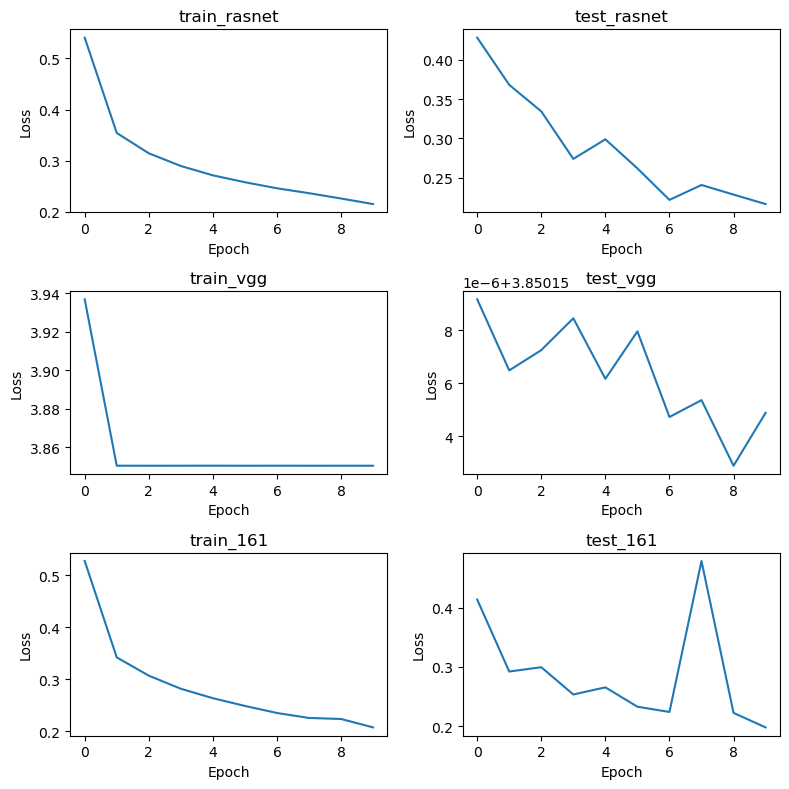

In [ ]:
cols, rows = 2, 3
figure = plt.figure(figsize=(8, 8))
for i in range(1, len(df.columns)+1):
    figure.tight_layout()
    figure.add_subplot(rows, cols, i)
    plt.title(df.columns[i-1])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(df[df.columns[i-1]].index, df[df.columns[i-1]].values)
plt.show()